## Text-to-Image Generation using Stable Diffusion and Diffusers

Contents of this notebook:

* how to generate images using text prompts
* the various diffusion pipelines for tasks such as text-to-image, image-to-image, text-to-music
* primary components of the diffusion pipeline: UNet model and schedulers

Diffusers library (HuggingFace): enables using SoTA diffusion models for generating images, audio, 3D structures of molecules

* Diffusion Pipeline wraps the complexity of the entire diffusion system into easy to use API

In [1]:
!pip install diffusers transformers gradio accelerate

In [2]:
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import torch

/opt/conda/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!pip show torch

Name: torch
Version: 2.4.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /opt/conda/envs/myenv/lib/python3.12/site-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvtx-cu12, setuptools, sympy, triton, typing-extensions
Required-by: accelerate


In [4]:
model_id1 = "dreamlike-art/dreamlike-diffusion-1.0"
model_id2 = "stabilityai/stable-diffusion-xl-base-1.0"

pipe = StableDiffusionPipeline.from_pretrained(model_id1, torch_dtype=torch.float16, use_safetensors=True)
# pipe = pipe.to("cuda")

Loading pipeline components...:  60%|█████▍   | 3/5 [00:01<00:00,  3.09it/s]/opt/conda/envs/myenv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|█████████| 5/5 [00:01<00:00,  4.28it/s]


In [5]:
prompt = """dreamlikeart, a grungy woman with rainbow hair, travelling between dimensions, dynamic pose, happy, soft eyes and narrow chin,
extreme bokeh, dainty figure, long hair straight down, torn kawaii shirt and baggy jeans
"""

In [6]:
pip install accelerator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
image = pipe(prompt).images[0]

  0%|                                                | 0/50 [00:00<?, ?it/s]

In [ ]:
print("[PROMPT]: ",prompt)
plt.imshow(image);
plt.axis('off');

In [ ]:
prompt2 = """dreamlike, Goddess coming down from the heaven with a weapon in one hand and other hand in the pose of blessing. Anger and divine energy
reflecting from her eyes.
She is in the form of a soldier and savior coming to protect the world from misery. She is accompanied by her tiger. Make sure to keep it cinematic and color to be golden iris
"""

image = pipe(prompt2).images[0]

In [ ]:
print('[PROMPT]: ',prompt2)
plt.imshow(image);
plt.axis('off');

https://huggingface.co/docs/diffusers/using-diffusers/loading

### Working with Stable Diffusion parameters

* Negative prompting
* num_inference_steps
* height
* weight
* num_images_per_prompt

In [ ]:
def generate_image(pipe, prompt, params):
  img = pipe(prompt, **params).images

  num_images = len(img)
  if num_images>1:
    fig, ax = plt.subplots(nrows=1, ncols=num_images)
    for i in range(num_images):
      ax[i].imshow(img[i]);
      ax[i].axis('off');

  else:
    fig = plt.figure()
    plt.imshow(img[0]);
    plt.axis('off');
  plt.tight_layout()

In [ ]:
prompt = "dreamlike, beautiful girl playing the festival of colors, draped in traditional Indian attire, throwing colors"

params = {}

  0%|          | 0/50 [00:00<?, ?it/s]

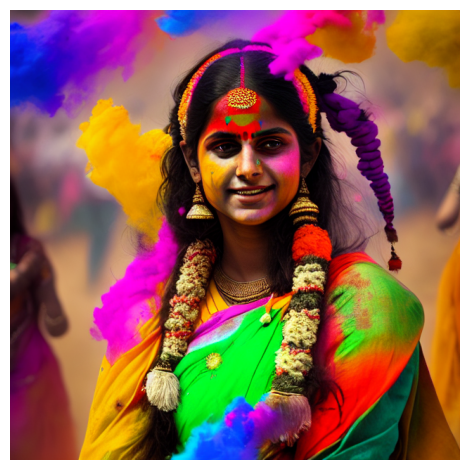

In [ ]:
generate_image(pipe, prompt, params)

  0%|          | 0/100 [00:00<?, ?it/s]

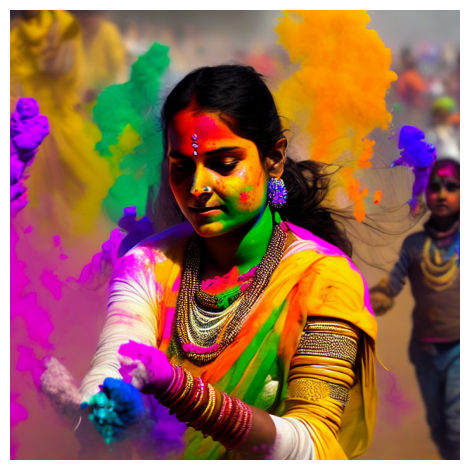

In [ ]:
#num inference steps
params = {'num_inference_steps': 100}

generate_image(pipe, prompt, params)

In [ ]:
#height width
params = {'num_inference_steps': 100, 'width': 512, 'height': int(1.5*640)}

generate_image(pipe, prompt, params)

In [ ]:
#num_images_per_prompt
params = {'num_inference_steps': 100, 'num_images_per_prompt': 2}

generate_image(pipe, prompt, params)

In [ ]:
# negative_prompt
params = {'num_inference_steps': 100, 'num_images_per_prompt': 2, 'negative_prompt': 'ugly, distorted, low quality'}

generate_image(pipe, prompt, params)

In [ ]:
generate_image(pipe, prompt2, params)

### Creating an interface

In [ ]:
def generate_image_interface(prompt, negative_prompt, num_inference_steps=50, weight=640):
  params = {'prompt': prompt, 'num_inference_steps': num_inference_steps, 'num_images_per_prompt':2, 'height':int(1.2*weight),
            'weight': weight, 'negative_prompt': negative_prompt}

  img = pipe(**params).images
  return img[0],img[1]

In [ ]:
import gradio as gr

In [ ]:
demo = gr.Interface(generate_image_interface, inputs=["text","text",gr.Slider(1,100),gr.Slider(512,640)], outputs=["image","image"])

In [ ]:
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ad210fbd7cef6ce51e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Understanding diffusion models

Diffusion models have beaten GANs in image generation

2 primary components

* UNet model: takes a random noise to generate the noise residual
* Scheduler: uses the noise residual to generate a less noisy image

Pipelines such as Stable diffusion, use additional component (tokenizers) to convert the prompt to embeddings